In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import data_generation as gen

## Synthetics generation

In [ ]:
signal, source, stations = gen.signal.generate_one_signal(plot=True)

#### TauP comparison

In [ ]:
# Source characteristics
source_lat = source[0]
source_lon = source[1]
source_depth = source[2]
print(f'Depth : {source_depth/1e3:.3f} km')

# Station position
station_lat = stations[0][0]
station_lon = stations[0][1]

In [ ]:
# My solution
P, pP, sP = gen.arrival_time.travel_times(source_lat, source_lon, source_depth, station_lat, station_lon)
tpP = pP - P
tsP = sP - P

# Results
print(f'P-pP: {tpP:.3f}s - P-sP: {tsP:.3f}s')

In [ ]:
# TauP solution
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees

# Kenett model AK135
model = TauPyModel(model="ak135")

distance_deg = locations2degrees(lat1=source_lat, long1=source_lon,
                                  lat2=station_lat, long2=station_lon)

arrivals = model.get_travel_times(source_depth_in_km=source_depth/1e3,
                                  distance_in_degree=distance_deg,
                                  phase_list=["P", "pP", "sP"])

# Results
tpP = arrivals[1].time - arrivals[0].time
tsP = arrivals[2].time - arrivals[0].time

print(f'P-pP: {tpP:.3f}s - P-sP: {tsP:.3f}s')

#### Generate matrix and plot

In [ ]:
signal_matrix, depth, _ = gen.matrix.generate_matrix(num_stations=50, depth=None, rand_inactive=0)

# Plot
plt.figure(figsize=(10,7))
plt.imshow(signal_matrix, aspect='auto', cmap='viridis', origin='upper')

# Adjust x-axis to represent time in seconds
num_columns = len(signal_matrix[0])  # Number of columns in the matrix
plt.xticks(
    ticks=np.arange(0, num_columns, step=200),  # Adjust step size as needed
    labels=np.arange(0, num_columns / 20, step=200 / 20)  # Convert to seconds (1/20 of a second since 20 Hz sampling)
)

#plt.colorbar(label='Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Signals (organized by distance)')
plt.title(f'Depth : {depth/1e3:.2f} km')
plt.tight_layout()
plt.suptitle('Main Energetic envelope of the Z-normalized signals aligned with P-arrival', fontsize=14, fontweight='bold', y=1.02)  # Add suptitle with y offset
plt.show()

## CNN-DNN model

#### Train a new model

In [2]:
model_name, train_losses, val_losses, test_loss = gen.depth_model.train_DepthModel(model_name="kernel3_org", batch_size=64, num_stations=50, rand_inactive=0, epochs=100, include_distance=True)

Successfully generated train dataset.
Successfully generated validation dataset.
Successfully generated test dataset.
Successfully initialized model using cuda.
Successfully set loss criterion and optimizer.


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Successfully trained model.
Saved model as "cuda_DepthModel_kernel3_org.pth".


#### Plot loss

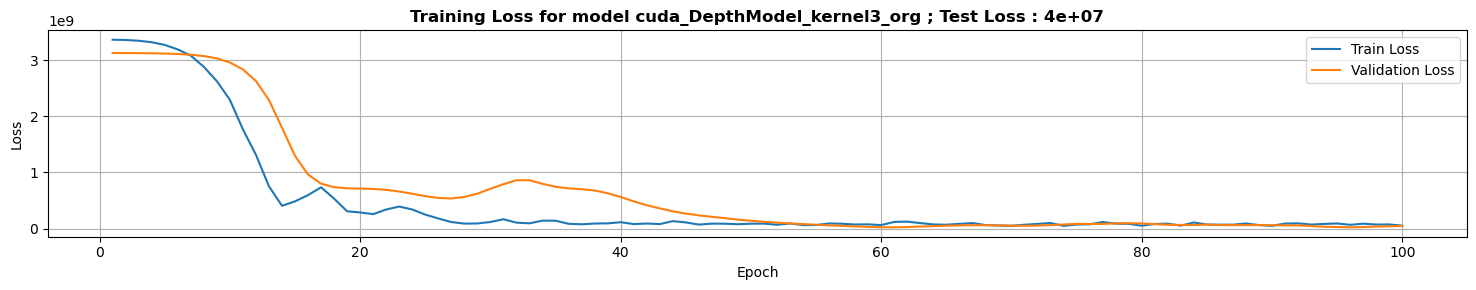

In [3]:
# Plot train loss vs epoch
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(15,3))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training Loss for model {model_name} ; Test Loss : {test_loss:.0e}", fontweight='bold')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"figures/Training Loss {model_name}.png", bbox_inches="tight")
plt.show()

#### Use an already existing model

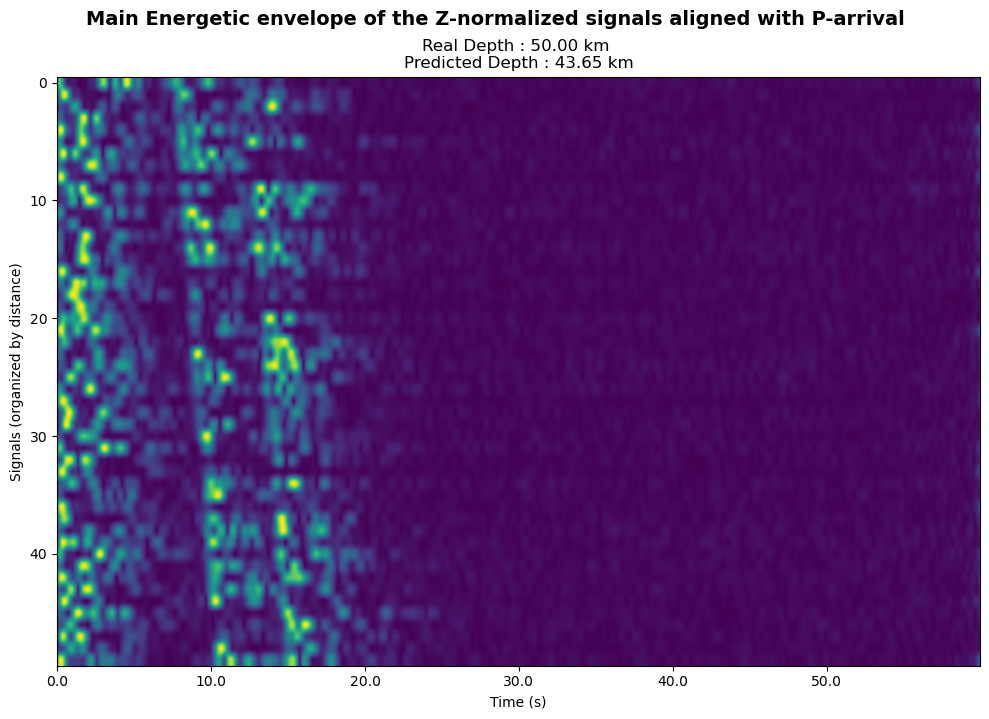

In [7]:
depth = [random.randint(0, 100)*1e3]  # Random depths in meters
depth = [50*1e3]  # Depths in meters
delta_depth = gen.depth_model.run_DepthModel(model_path="cuda_DepthModel_kernel3_org.pth", num_stations=50, rand_inactive=0, include_distance=True, depth_list=depth, plot=True, save_plot=True)

In [ ]:
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2} MB")
print(f"Cached: {torch.cuda.memory_reserved() / 1024**2} MB")